## To Do:
- Deal with records that have RDATE before ADATE
- (?) (Probably doesn't make sense) Do something with this information (from metadata text file):
                            LL mailings had labels only
                            WL mailings had labels only
                            CC mailings are calendars with stickers but do
                               not have labels
                            FS mailings are blank cards that fold into
                               thirds with labels
                            NK mailings are blank cards with labels
                            SK mailings are blank cards with labels
                            TK mailings have thank you printed on the
                               outside with labels
                            GK mailings are general greeting cards (an
                               assortment of birthday, sympathy, blank, & get
                               well) with labels
                            XK mailings are Christmas cards with labels
                            X1 mailings have labels and a notepad
                            G1 mailings have labels and a notepad
- Use the variable that is most correlated with 'Age' ('Age' is yet to be created from 'DOB') to fill in the missing values of 'Age' (using a linear model for example)
- As a final check for outlier detection, use DBSCAN to see if all outliers were excluded
- Henrique's notes:
    - I had one note in my notebook we should turn ODATE into number of months for RFA matters maybe and DOB to days
        - -> <span style="color:red">Turned all date features into days relative to ADATE_2</span>
    - Another one saying that NOEXCH could be remove. Check it out a see if you agree
        - <span style="color:red">This one doesn't seem too bad to me so far actually</span>
- Decide what to do with 'HOMEOWNR' (Home Owner Flag, H = Home owner, U = Unknown)
    - pd.unique(donors.HOMEOWNR) ---> array([nan, 'H', 'U'], dtype=object)
    - Could be incuded as: "Home owner" = 1, "No home owner" = 0, "Unknown" = nan
    - But does it make sense to use binary variables for clustering?
- What was done in the "clustering" lab: Use DBSCAN to remove outliers. Do the clustering on the inliers. Then in the end add each outlier to the closest cluster.

## <span style="color:red">Insights from the Q&A on Thursday, 10. Dec. 2020:</span>

<span style="color:red">**See text file "Notes Q&A 10. Dec. 2020" in folder "PDFs and notes"**</span>

## Import libraries

In [1]:
import pandas as pd
import os
import numpy as np
import datetime
import dateutil.relativedelta
from datetime import date
import math
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

%matplotlib inline

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Seeting seaborn style
sns.set()

In [2]:
# Turn off warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Load data

In [3]:
# Load data
donors = pd.read_csv(os.path.join('Data and metadata', 'donors.csv'), sep=',', index_col=0)

In [4]:
donors

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,6.864865,7112,1,L,2,F,X,X,X,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,2016-01-01,ASE,1,AK,99504,,,NaN,0,,...,25.000000,184568,0,L,1,G,X,X,X,C
95408,2016-01-01,DCD,1,TX,77379,,,1970-01-01,0,,...,20.000000,122706,1,L,1,F,X,X,X,A
95409,2015-01-01,MBC,1,MI,48910,,,1958-01-01,0,,...,8.285714,189641,1,L,3,E,X,X,X,B
95410,2006-01-01,PRV,0,CA,91320,,,1960-05-01,0,X,...,12.146341,4693,1,L,4,F,X,X,X,A


In [5]:
# Save the original features in a list
features_orig = list(donors)

## Code for checking the types of all elements of a column

In [6]:
feature = 'ADATE_2'
type_items_to_retieve = float
type_set = set()
list_ = []
for item in donors[feature]:
    type_ = type(item)
    type_set.add(type_)
    if type_ == type_items_to_retieve:
        list_.append(item)
print('Types present in this feature:')
print(type_set)
print('Items that have type', type_items_to_retieve, ':')
print(pd.unique(list_))

Types present in this feature:
{<class 'str'>}
Items that have type <class 'float'> :
[]


## Separate metric features from non-metric features

In [7]:
# Look at top of remaining dataset
donors.head(5)

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,6.864865,7112,1,L,2,F,X,X,X,A


In [8]:
## Obtain information of the type of a certain feature
feature = 'HOMEOWNR'

# Print its type
print('dtype of feature', feature, ':', donors.dtypes[feature])

# Take a closer look at the first non nan element of it
first_non_na_element = donors[feature][~donors[feature].isna()].iloc[0]
print('First non nan element of this feature:', first_non_na_element)
print('Class of the first element of this feature:', type(first_non_na_element))

# View the unique values of this feature
# print('Sorted unique values of feature', feature, ':', np.sort(pd.unique(donors[feature])))
print('Unique values of feature', feature, ':', pd.unique(donors[feature]))

dtype of feature HOMEOWNR : object
First non nan element of this feature:  
Class of the first element of this feature: <class 'str'>
Unique values of feature HOMEOWNR : [' ' 'H' 'U']


In [9]:
# Create a list with the metric features
# Including dates and other variables that might still be Strings at this point
# Will use 'to_num' on all metric features in the next step
metric_features = ['ODATEDW',
 'DOB',
 'NUMCHLD',
 'INCOME',
 'WEALTH1',
 'HIT',
                   # Above: Information about the donor
                   # Below: About the number of times the donor has responded to other types of mail order offers
 'MBCRAFT',
 'MBGARDEN',
 'MBBOOKS',
 'MBCOLECT',
 'MAGFAML',
 'MAGFEM',
 'MAGMALE',
 'PUBGARDN',
 'PUBCULIN',
 'PUBHLTH',
 'PUBDOITY',
 'PUBNEWFN',
 'PUBPHOTO',
 'PUBOPP',
                   # Below: Data from third party regarding the household or neighborhood (According to David Silva) 
 'MALEMILI',
 'MALEVET',
 'VIETVETS',
 'WWIIVETS',
 'LOCALGOV',
 'STATEGOV',
 'FEDGOV',         
 'SOLP3',
 'SOLIH',
 'WEALTH2',
                   # Below: About donor's neighbourhood
 'POP901',
 'POP902',
 'POP903',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'POP90C4',
 'POP90C5',
 'ETH1',
 'ETH2',
 'ETH3',
 'ETH4',
 'ETH5',
 'ETH6',
 'ETH7',
 'ETH8',
 'ETH9',
 'ETH10',
 'ETH11',
 'ETH12',
 'ETH13',
 'ETH14',
 'ETH15',
 'ETH16',              
 'AGE901',
 'AGE902',
 'AGE903',
 'AGE904',
 'AGE905',
 'AGE906',
 'AGE907',
 'CHIL1',
 'CHIL2',
 'CHIL3',
 'AGEC1',
 'AGEC2',
 'AGEC3',
 'AGEC4',
 'AGEC5',
 'AGEC6',
 'AGEC7',
 'CHILC1',
 'CHILC2',
 'CHILC3',
 'CHILC4',
 'CHILC5',
 'HHAGE1',
 'HHAGE2',
 'HHAGE3',
 'HHN1',
 'HHN2',
 'HHN3',
 'HHN4',
 'HHN5',
 'HHN6',
 'MARR1',
 'MARR2',
 'MARR3',
 'MARR4',           
 'HHP1',
 'HHP2',
 'DW1',
 'DW2',
 'DW3',
 'DW4',
 'DW5',
 'DW6',
 'DW7',
 'DW8',
 'DW9',
 'HV1',
 'HV2',
 'HV3',
 'HV4',
 'HU1',
 'HU2',
 'HU3',
 'HU4',
 'HU5',                  
 'HHD1',
 'HHD2',
 'HHD3',
 'HHD4',
 'HHD5',
 'HHD6',
 'HHD7',
 'HHD8',
 'HHD9',
 'HHD10',
 'HHD11',
 'HHD12',
 'ETHC1',
 'ETHC2',
 'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'HVP1',
 'HVP2',
 'HVP3',
 'HVP4',
 'HVP5',
 'HVP6',                  
 'HUR1',
 'HUR2',
 'RHP1',
 'RHP2',
 'RHP3',
 'RHP4',
 'HUPA1',
 'HUPA2',
 'HUPA3',
 'HUPA4',
 'HUPA5',
 'HUPA6',
 'HUPA7',
 'RP1',
 'RP2',
 'RP3',
 'RP4',                 
 'IC1',
 'IC2',
 'IC3',
 'IC4',
 'IC5',
 'IC6',
 'IC7',
 'IC8',
 'IC9',
 'IC10',
 'IC11',
 'IC12',
 'IC13',
 'IC14',
 'IC15',
 'IC16',
 'IC17',
 'IC18',
 'IC19',
 'IC20',
 'IC21',
 'IC22',
 'IC23',           
 'HHAS1',
 'HHAS2',
 'HHAS3',
 'HHAS4',
 'MC1',
 'MC2',
 'MC3',
 'TPE1',
 'TPE2',
 'TPE3',
 'TPE4',
 'TPE5',
 'TPE6',
 'TPE7',
 'TPE8',
 'TPE9',
 'PEC1',
 'PEC2',
 'TPE10',
 'TPE11',
 'TPE12',
 'TPE13',
 'LFC1',
 'LFC2',
 'LFC3',
 'LFC4',
 'LFC5',
 'LFC6',
 'LFC7',
 'LFC8',
 'LFC9',
 'LFC10',
 'OCC1',
 'OCC2',
 'OCC3',
 'OCC4',
 'OCC5',
 'OCC6',
 'OCC7',
 'OCC8',
 'OCC9',
 'OCC10',
 'OCC11',
 'OCC12',
 'OCC13',
 'EIC1',
 'EIC2',
 'EIC3',
 'EIC4',
 'EIC5',
 'EIC6',
 'EIC7',
 'EIC8',
 'EIC9',
 'EIC10',
 'EIC11',
 'EIC12',
 'EIC13',
 'EIC14',
 'EIC15',
 'EIC16',
 'OEDC1',
 'OEDC2',
 'OEDC3',
 'OEDC4',
 'OEDC5',
 'OEDC6',
 'OEDC7',
 'EC1',
 'EC2',
 'EC3',
 'EC4',
 'EC5',
 'EC6',
 'EC7',
 'EC8',
 'SEC1',
 'SEC2',
 'SEC3',
 'SEC4',
 'SEC5',
 'AFC1',
 'AFC2',
 'AFC3',
 'AFC4',
 'AFC5',
 'AFC6',
 'VC1',
 'VC2',
 'VC3',
 'VC4',
 'ANC1',
 'ANC2',
 'ANC3',
 'ANC4',
 'ANC5',
 'ANC6',
 'ANC7',
 'ANC8',
 'ANC9',
 'ANC10',
 'ANC11',
 'ANC12',
 'ANC13',
 'ANC14',
 'ANC15',
 'POBC1',
 'POBC2',
 'LSC1',
 'LSC2',
 'LSC3',
 'LSC4',
 'VOC1',
 'VOC2',
 'VOC3',
 'HC1',
 'HC2',
 'HC3',
 'HC4',
 'HC5',
 'HC6',
 'HC7',
 'HC8',
 'HC9',
 'HC10',
 'HC11',
 'HC12',
 'HC13',
 'HC14',
 'HC15',
 'HC16',
 'HC17',
 'HC18',
 'HC19',
 'HC20',
 'HC21',
 'MHUC1',
 'MHUC2',
 'AC1',
 'AC2',
                   # Above: About donor's neighbourhood      
                   # Below: Date promotion X was mailed
 'ADATE_2',
 'ADATE_3',
 'ADATE_4',
 'ADATE_5',
 'ADATE_6',
 'ADATE_7',
 'ADATE_8',
 'ADATE_9',
 'ADATE_10',
 'ADATE_11',
 'ADATE_12',
 'ADATE_13',
 'ADATE_14',
 'ADATE_15',
 'ADATE_16',
 'ADATE_17',
 'ADATE_18',
 'ADATE_19',
 'ADATE_20',
 'ADATE_21',
 'ADATE_22',
 'ADATE_23',
 'ADATE_24',
                   # Below: Information about how many promotions donor has received
 'CARDPROM',
 'MAXADATE',
 'NUMPROM',
 'CARDPM12',
 'NUMPRM12',
                   # Below: Date the donation was received
 'RDATE_3',
 'RDATE_4',
 'RDATE_5',
 'RDATE_6',
 'RDATE_7',
 'RDATE_8',
 'RDATE_9',
 'RDATE_10',
 'RDATE_11',
 'RDATE_12',
 'RDATE_13',
 'RDATE_14',
 'RDATE_15',
 'RDATE_16',
 'RDATE_17',
 'RDATE_18',
 'RDATE_19',
 'RDATE_20',
 'RDATE_21',
 'RDATE_22',
 'RDATE_23',
 'RDATE_24',
                   # Below: Dollar amount of the donation
 'RAMNT_3',
 'RAMNT_4',
 'RAMNT_5',
 'RAMNT_6',
 'RAMNT_7',
 'RAMNT_8',
 'RAMNT_9',
 'RAMNT_10',
 'RAMNT_11',
 'RAMNT_12',
 'RAMNT_13',
 'RAMNT_14',
 'RAMNT_15',
 'RAMNT_16',
 'RAMNT_17',
 'RAMNT_18',
 'RAMNT_19',
 'RAMNT_20',
 'RAMNT_21',
 'RAMNT_22',
 'RAMNT_23',
 'RAMNT_24',
                   # Below: Summary variables for this donor
 'RAMNTALL',
 'NGIFTALL',
 'CARDGIFT',
 'MINRAMNT',
 'MINRDATE',
 'MAXRAMNT',
 'MAXRDATE',
 'LASTGIFT',
 'LASTDATE',
 'FISTDATE',
 'NEXTDATE',
 'TIMELAG',
 'AVGGIFT']

print('Number of metric features:', len(metric_features))

# Save this oroginal metric features list
metric_features_orig = metric_features.copy()

Number of metric features: 398


In [10]:
# Create a list with the non metrics features by excluding the metric ones
non_metric_features = donors.columns.drop(metric_features).to_list()

print('Number of non-metric features:', len(non_metric_features))

# Save this oroginal metric features list
non_metric_features_orig = non_metric_features.copy()

Number of non-metric features: 77


## Treat features where " " (space) carries a meaning

**MAILCODE**

In [11]:
feature = 'MAILCODE'
pd.unique(donors[feature])

array([' ', 'B'], dtype=object)

In [12]:
donors[feature].replace(" ", "Address is OK", inplace=True)
donors[feature].replace("B", "Bad Address", inplace=True)
pd.unique(donors[feature])

array(['Address is OK', 'Bad Address'], dtype=object)

**NOEXCH**

In [13]:
feature = 'NOEXCH'
pd.unique(donors[feature])

array(['0', '1', 'X', 0, 1, ' '], dtype=object)

In [14]:
donors[feature].replace(" ", "can be exchanged", inplace=True)
donors[feature].replace("X", "do not exchange", inplace=True)
# Assumption: 1 = do not exchange, 0 = can be exchanged (Makes sense because of the variable name)
donors[feature].replace('0', "can be exchanged", inplace=True)
donors[feature].replace('1', "do not exchange", inplace=True)
donors[feature].replace(0, "can be exchanged", inplace=True)
donors[feature].replace(1, "do not exchange", inplace=True)
pd.unique(donors[feature])

array(['can be exchanged', 'do not exchange'], dtype=object)

**RECINHSE**

In [15]:
feature = 'RECINHSE'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [16]:
donors[feature].replace(" ", "Not an In House Record", inplace=True)
donors[feature].replace("X", "Donor has given to PVA's In House program", inplace=True)
pd.unique(donors[feature])

array(['Not an In House Record',
       "Donor has given to PVA's In House program"], dtype=object)

**RECP3**

In [17]:
feature = 'RECP3'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [18]:
donors[feature].replace(" ", "Not a P3 Record", inplace=True)
donors[feature].replace("X", "Donor has given to PVA's P3 program", inplace=True)
pd.unique(donors[feature])

array(['Not a P3 Record', "Donor has given to PVA's P3 program"],
      dtype=object)

**RECPGVG**

In [19]:
feature = 'RECPGVG'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [20]:
donors[feature].replace(" ", "Not a Planned Giving Record", inplace=True)
donors[feature].replace("X", "Planned Giving Record", inplace=True)
pd.unique(donors[feature])

array(['Not a Planned Giving Record', 'Planned Giving Record'],
      dtype=object)

**RECSWEEP**

In [21]:
feature = 'RECSWEEP'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [22]:
donors[feature].replace(" ", "Not a Sweepstakes Record", inplace=True)
donors[feature].replace("X", "Sweepstakes Record", inplace=True)
pd.unique(donors[feature])

array(['Not a Sweepstakes Record', 'Sweepstakes Record'], dtype=object)

**MAJOR**

In [23]:
feature = 'MAJOR'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [24]:
donors[feature].replace(" ", "Not a Major Donor", inplace=True)
donors[feature].replace("X", "Major Donor", inplace=True)
pd.unique(donors[feature])

array(['Not a Major Donor', 'Major Donor'], dtype=object)

## Asses existance of nan values and duplictes and deal with empty strings

In [25]:
# See how many duplicated observations exist
donors.duplicated().sum()

0

In [26]:
# List the variables that have missing values and their missing value counts
missing_value_counts = donors.isna().sum()[donors.isna().sum()!=0]
missing_value_counts

DOB         23883
NUMCHLD     83026
INCOME      21286
WEALTH1     44732
MBCRAFT     52854
            ...  
RAMNT_24    77674
FISTDATE        2
NEXTDATE     9973
TIMELAG      9973
GEOCODE2      132
Length: 92, dtype: int64

In [27]:
# Get the total number of nan values
donors.isna().sum()[donors.isna().sum()!=0].sum()

5158884

In [28]:
# Replace " " by nans
donors.replace(" ", np.nan, inplace=True)

In [29]:
# Get the total number of nan values once more
donors.isna().sum()[donors.isna().sum()!=0].sum()

8170773

<span style="color:red">**About 3 million " " (spaces) were converted to nan.**</span>

In [30]:
# Replace "" by nans
donors.replace("", np.nan, inplace=True)

In [31]:
# Get the total number of nan values once more
donors.isna().sum()[donors.isna().sum()!=0].sum()

8170773

<span style="color:red">**No additional nans added in this step.**</span>

## Assess the percentage of missing values per feature and drop the features that have more than 40% mssing values

In [32]:
# Create an empty list
nan_percentage_list = []

# Loop over the list of features and compute their percentage of nan values
for feature in list(donors):
    nan_percentage = len(donors[feature][donors[feature].isna()]) / len(donors[feature]) * 100
    nan_percentage_list.append(nan_percentage)
    
# Create a look-up table
nan_percentage_series = pd.Series(data=nan_percentage_list, index=list(donors))
nan_percentage_series

ODATEDW     0.000000
OSOURCE     0.972624
TCODE       0.000000
STATE       0.000000
ZIP         0.000000
              ...   
RFA_2A      0.000000
MDMAUD_R    0.000000
MDMAUD_F    0.000000
MDMAUD_A    0.000000
GEOCODE2    0.334339
Length: 475, dtype: float64

In [33]:
# Get a list of the features that have a higher amount of missing values
lower_nan_percentage = nan_percentage_series[nan_percentage_series<=40].index.tolist()

# Get a list of the features that have a lower amount of missing values
higher_nan_percentage = nan_percentage_series[nan_percentage_series>40].index.tolist()

# For report: Save the names of the features with the lower nan percentage in the variable 
# "features_dropped_due_to_nans"
features_dropped_due_to_nans = higher_nan_percentage

In [34]:
donors_1 = donors[lower_nan_percentage]
donors_1

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,DOB,NOEXCH,RECINHSE,RECP3,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,Address is OK,1957-12-01,can be exchanged,Not an In House Record,Not a P3 Record,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,Address is OK,1972-02-01,can be exchanged,Not an In House Record,Not a P3 Record,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,Address is OK,NaN,can be exchanged,Not an In House Record,Not a P3 Record,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,Address is OK,1948-01-01,can be exchanged,Not an In House Record,Not a P3 Record,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,NaN,0,FL,33176,Address is OK,1940-01-01,can be exchanged,Donor has given to PVA's In House program,Donor has given to PVA's P3 program,...,6.864865,7112,1,L,2,F,X,X,X,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,2016-01-01,ASE,1,AK,99504,Address is OK,NaN,can be exchanged,Not an In House Record,Not a P3 Record,...,25.000000,184568,0,L,1,G,X,X,X,C
95408,2016-01-01,DCD,1,TX,77379,Address is OK,1970-01-01,can be exchanged,Not an In House Record,Not a P3 Record,...,20.000000,122706,1,L,1,F,X,X,X,A
95409,2015-01-01,MBC,1,MI,48910,Address is OK,1958-01-01,can be exchanged,Not an In House Record,Donor has given to PVA's P3 program,...,8.285714,189641,1,L,3,E,X,X,X,B
95410,2006-01-01,PRV,0,CA,91320,Address is OK,1960-05-01,can be exchanged,Donor has given to PVA's In House program,Not a P3 Record,...,12.146341,4693,1,L,4,F,X,X,X,A


In [35]:
# Accept the changes
donors = donors_1

In [36]:
def sort_features(original_order, shuffled):
    ordered = []
    for feature in original_order:
        if feature in shuffled:
            ordered.append(feature)
    return ordered

In [37]:
# Update 'metric_features' list

# Print the number of metric features before the removal
print('Number of metric features before removal:', len(metric_features))

# Get the features that are metric features and still exist in our dataset
metric_features = list(set(metric_features).intersection(set(donors)))

# And sort them according to our original order
metric_features = sort_features(metric_features_orig, metric_features)

# Print the number of metric features after the removal
print('Number of metric features afer removal:', len(metric_features))

Number of metric features before removal: 398
Number of metric features afer removal: 331


In [38]:
# Update 'non_metric_features' list

# Print the number of metric features before the removal
print('Number of non-metric features before removal:', len(non_metric_features))

# Get the features that are metric features and still exist in our dataset
non_metric_features = list(set(non_metric_features).intersection(set(donors)))

# And sort them according to our original order
non_metric_features = sort_features(non_metric_features_orig, non_metric_features)

# Print the number of metric features after the removal
print('Number of non-metric features afer removal:', len(non_metric_features))

Number of non-metric features before removal: 77
Number of non-metric features afer removal: 47


In [39]:
# Get the total number of nan values once more
donors.isna().sum()[donors.isna().sum()!=0].sum()

770663

<span style="color:red">**Before: About 8 million nans. Now: Less than 1 million nans.**</span>

## Transform columns containing dates to datetime format

In [40]:
def series_string_to_date_if_not_nan(x):
    """This function checks if something is a string, and if so, converts it into a datetime object"""
    # If it's not a nan, but a string
    if type(x)==str:
        x = datetime.datetime.strptime(x, '%Y-%m-%d').date()
    # if it's a nan, change to NaT
    # else:
    #     x = pd.NaT
    return x

In [41]:
# Define a function for converting series containing strings to series containing datetime objects
def series_string_to_date(series):
    """This function turns a pandas series that consists of String values into a pandas series containing 
    datetime objects"""
    series_datetime = series.map(lambda x: series_string_to_date_if_not_nan(x))
    return series_datetime

In [42]:
def replace_string_col_by_date_col(df, colname):
    """This function uses 'series_string_to_date' for replacing a string column by a datetime object column"""
    df[colname] = series_string_to_date(df[colname])

In [43]:
# Code for checking data types
if False:
    labels_types = pd.DataFrame({'Labels':list(donors), 'Data types':list(donors.dtypes)})
    labels_types[0:10]

In [44]:
# Define the labels who's columns should be changed to datetime
date_features = [
    'ODATEDW',
    'DOB',
    'ADATE_2',
    'ADATE_3',
    'ADATE_4',
    'ADATE_5',
    'ADATE_6',
    'ADATE_7',
    'ADATE_8',
    'ADATE_9',
    'ADATE_10',
    'ADATE_11',
    'ADATE_12',
    'ADATE_13',
    'ADATE_14',
    'ADATE_15',
    'ADATE_16',
    'ADATE_17',
    'ADATE_18',
    'ADATE_19',
    'ADATE_20',
    'ADATE_21',
    'ADATE_22',
    'ADATE_23',
    'ADATE_24',
    'MAXADATE',
    'RDATE_3',
    'RDATE_4',
    'RDATE_5',
    'RDATE_6',
    'RDATE_7',
    'RDATE_8',
    'RDATE_9',
    'RDATE_10',
    'RDATE_11',
    'RDATE_12',
    'RDATE_13',
    'RDATE_14',
    'RDATE_15',
    'RDATE_16',
    'RDATE_17',
    'RDATE_18',
    'RDATE_19',
    'RDATE_20',
    'RDATE_21',
    'RDATE_22',
    'RDATE_23',
    'RDATE_24',
    'MINRDATE',
    'MAXRDATE',
    'LASTDATE',
    'FISTDATE',
    'NEXTDATE',
]

# Save this original list of date features
date_features_orig = date_features.copy()

# Get the features that are date features and still exist in our dataset
date_features = list(set(date_features).intersection(set(donors)))

# And sort them according to our original order
date_features = sort_features(date_features_orig, date_features)

In [45]:
# Code for checking the existing datatypes in a given columns
# This needs some work. Doesn't always work properly
if False:
    feature = 'NUMCHLD'
    unique_types = set()
    str_indices = []
    float_indices = []
    other_indices = []
    for i in range(len(donors[feature])):
        if type(donors[feature][i])==str:
                str_indices.append(i)
        if type(donors[feature][i])==float:
                float_indices.append(i)
        else:
                other_indices.append(i)
        unique_types.add(type(donors[feature][i]))
    nans = donors[feature][float_indices]
    strings = donors[feature][str_indices]
    print('Strings:', strings)
    print('Floats (can be NaNs):', nans)
    print('Contains the following data types:', unique_types)

In [46]:
# Use the functions defined above to change all non-nan values of the columns in 'date_features' datetime objects
for label_to_change in date_features:
    replace_string_col_by_date_col(donors, label_to_change)

In [47]:
# Check that it worked properly
for i in range(len(date_features)):
    print(type(donors[date_features[i]][0]))

<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>


In [48]:
# Check if time calculations work properly with these columns
now = date.today()
now - donors['DOB']
# Seems to work well.

0       23025 days
1       17850 days
2              NaT
3       26647 days
4       29569 days
           ...    
95407          NaT
95408   18611 days
95409   22994 days
95410   22143 days
95411   30299 days
Name: DOB, Length: 95412, dtype: timedelta64[ns]

## Create pandas-profiling report

In [49]:
now_string = str(datetime.datetime.now())

profile = ProfileReport(
    donors, 
    title='Donors Data',
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
    minimal = False
)

In [50]:
folder_path = os.path.join('pandas-profiling', now_string)

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [51]:
if False:
    profile.to_file(os.path.join(folder_path, "pandas_profiling.html"))

## Data cleaning

In [52]:
# Adapted from "lab04_data_visualization" (Data Mining)
def single_hist(feature, *n_of_bins):
    """This function takes feature name and produces a visualisation of the histogram of the respective feature"""
    # Single Metric Variable Histogram
    if len(n_of_bins)==0:
        plt.hist(donors[feature])
    else:
        print('Number of bins:', n_of_bins[0])
        plt.hist(donors[feature], bins = n_of_bins[0])
    plt.title(feature, y=-0.2)
    
    # Save figure and include time stamp in filename
    now_string = str(datetime.datetime.now())
    folder_path = os.path.join('figures')
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = now_string + '_single_histogram.png'
    plt.savefig(os.path.join(folder_path, filename), dpi=200)

    plt.show()

In [53]:
def remove_value(feature, value):
    """This function takes a feature name and a value and turns all elements of the respective column with this value
    into nans."""
    series = donors[feature].copy()
    series[series==value]=np.nan
    donors[feature] = series

**Remove value 0 from columns 'AGE901' to 'AGE907'**

Number of bins: 100


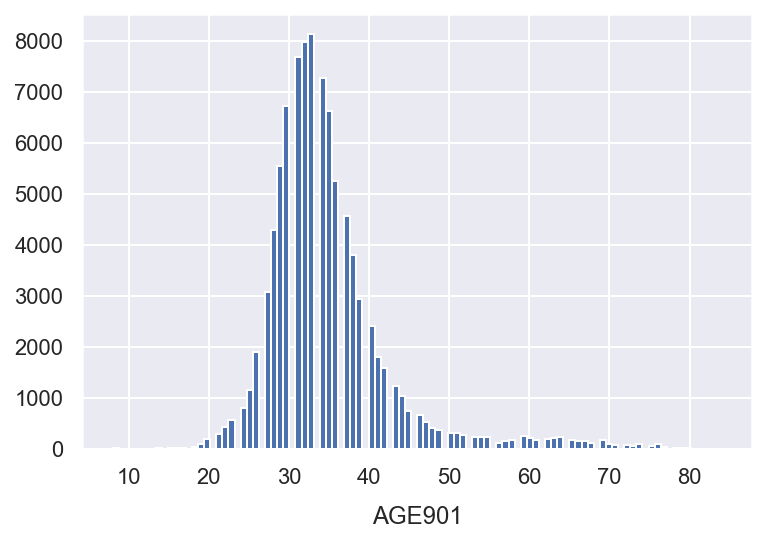

In [67]:
feature = 'AGE901'
single_hist(feature, 100)

In [55]:
for feature in ['AGE901',
    'AGE902',
    'AGE903',
    'AGE904',
    'AGE905',
    'AGE906',
    'AGE907']:
    remove_value(feature, 0)

Number of bins: 100


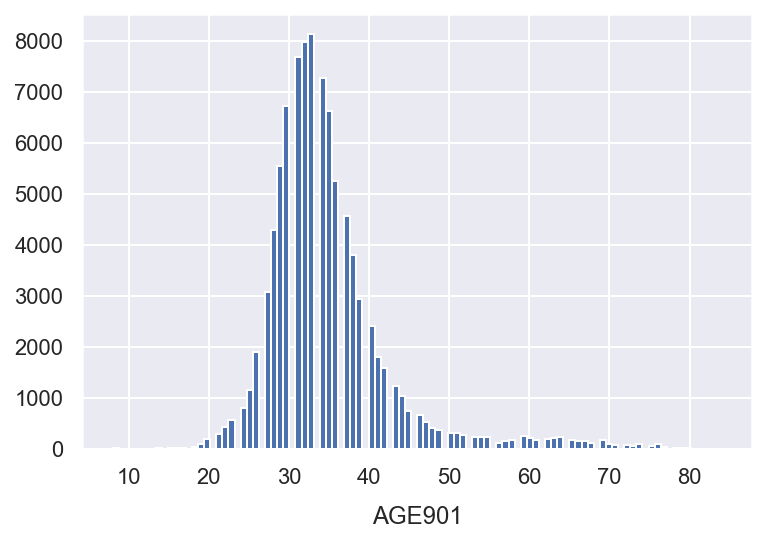

In [56]:
feature = 'AGE901'
single_hist(feature, 100)

### Treat the cases where 'LASTDATE' suggests that donor is not lapsing or lapsed (In this dataset, all donors should be either lapsing or lapsed)

<span style="color:red">**We have to check this! I feel like I remove too many observations here.**<span>

Forum entry "Lapsed donors"

Entry by David Silva - Thursday, 3 December 2020, 9:43 AM
 	
"Hi Philipp,

Yes. A lapsed donor is a "snapshot" label so it depends on a point in time. The lapsed donors in this dataset are determined according to the date the last promotion (17NK) was emailed to each one of them and the date of their most recent gift. Inconsistent observations are the ones which have an interval between these two dates smaller than 13 months as according to the Lapsed donors description: "A previous donor who made their donation between 13-24 months ago"."

In [57]:
# Only execute if flag=True
flag = False

In [58]:
if flag:
    # Create a series that contains the dates from 'adate_2' substacted by 13 months
    adate_2_minus_13_months = donors.ADATE_2.map(lambda x: x - dateutil.relativedelta.relativedelta(months=13))
    adate_2_minus_13_months

In [59]:
if flag:
    # Check if it worked properly
    (donors.ADATE_2 - adate_2_minus_13_months) / 13

In [60]:
if flag:
    # Remove inconsistent values from donors
    # Inconsistent values are the ones where 'adate_2_minus_13_months' is before 'LASTDATE'
    # All observations that are not inconsistent are kept.
    donors_2 = donors[~(adate_2_minus_13_months < donors['LASTDATE'])]

    percentage_discarded = ((donors.shape[0] - donors_2.shape[0]) / donors.shape[0])*100
    print('Percentage of observation discarded due to inconsistency between their "lapsed" status and their LASTDATE value:')
    print(round(percentage_discarded, 2), '%')

In [61]:
if flag:
    # Accept the changes
    donors = donors_2

## Discard useless features

In [77]:
# Adapted from "lab04_data_visualization" (Data Mining)
def corr_matrix_visualisation(features):
    """This function takes a list of features and created a visualisation of their correlation matrix."""
    
    # Prepare figure
    fig = plt.figure(figsize=(10, 8))

    # Obtain correlation matrix. Round the values to 4 decimal cases. Use the DataFrame corr() and round() method.
    corr = np.round(donors[features].corr(method="pearson"), decimals=4)

    # Build annotation matrix (values above |bound| will appear annotated in the plot)
    bound = 0
    mask_annot = np.absolute(corr.values) >= bound
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Correlation Matrix", fontsize=20)

    # Save figure and include time stamp and the feature names in the filename
    now_string = str(datetime.datetime.now())
    folder_path = os.path.join('figures')
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = now_string + '_' +  '-'.join(features) + '_corr_matrix.png'
    plt.savefig(os.path.join(folder_path, filename), dpi=200)

    plt.show()

In [91]:
def uniques_nans_variance(feature):
    """This function takes the name of a feature and prints its unique values, its percentage of missing values and
    its standard deviation. Then it returns the respective column so it is displayed as output."""
    
    print('Unique values:')
    unique = pd.unique(donors[feature])
    unique.sort()
    print(unique)
    print()
    print('Percentage of missing values:')
    print(round(len(donors[feature][donors[feature].isna()])/len(donors[feature]), 4), '%')
    print()
    print('Minimum value:', donors[feature].min(), '- Share:', round(((len(donors[feature][donors[feature]==donors[feature].min()])) / len(donors[feature])),4), '%')
    print('Maximum value:', donors[feature].max(), '- Share:', round(((len(donors[feature][donors[feature]==donors[feature].max()])) / len(donors[feature])),4), '%')
    print()
    try:
        print('Sample standard deviation:', round(donors[feature].std(), 4))
    except:
        print("Couldn't compute a variance")
        
    return donors[feature]

In [126]:
def df_nans_variance_min_max(features):
    """This function takes a list of features and computes their percentages of missing values, their sample
    standard deviations, their Minima and Maxima and the percentage of how much the minima and maxima are in
    this feature. Then it saves all this in a DataFrame which it returns."""
    nans = []
    st_devs = []
    mins = []
    min_shares = []
    maxs = []
    max_shares = []
    for feature in features:
        nans.append(round(len(donors[feature][donors[feature].isna()])/len(donors[feature]), 4))
        st_devs.append(round(donors[feature].std(), 4))
        mins.append(donors[feature].min())
        min_shares.append(round(((len(donors[feature][donors[feature]==donors[feature].min()])) \
                                 / len(donors[feature])),4))
        maxs.append(donors[feature].max())
        max_shares.append(round(((len(donors[feature][donors[feature]==donors[feature].max()])) \
                                 / len(donors[feature])),4))
    
    df = pd.DataFrame(data = {'Missing values [%]': nans, 'Sample standard deviation [Unit of feature]': st_devs, 'Minimum [Unit of f.]': mins,\
                              'Share of Minimum [%]:': min_shares, 'Maximum [Unit of f.]': maxs, 'Share of Maximum [%]': max_shares},\
                      index = features)
    return df

In [142]:
features = [
    'POP901', # ("Number of Persons")
    'POP902', # ("Number of Families")
    'POP903' # ("Number of Households")
]

In [143]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
POP901,0.0,5743.2173,0,0.0084,98701,0.0001
POP902,0.0,1458.1034,0,0.0088,23766,0.0000
POP903,0.0,2123.0962,0,0.0086,35403,0.0000


In [144]:
df_nans_variance_min_max(features)['Sample standard deviation [Unit of feature]']

POP901    5743.2173
POP902    1458.1034
POP903    2123.0962
Name: Sample standard deviation [Unit of feature], dtype: float64

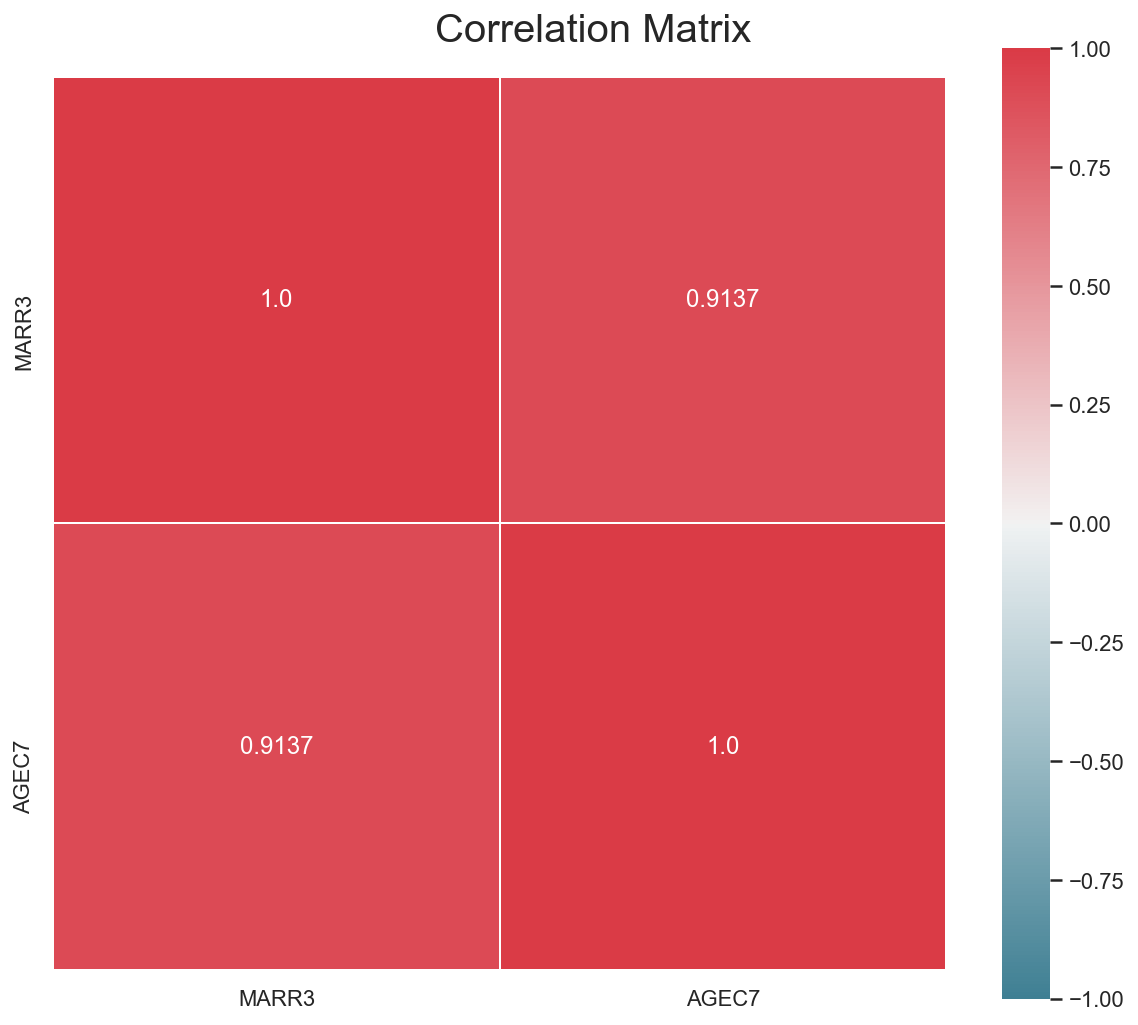

In [89]:
corr_matrix_visualisation(features)

In [ ]:
# Following direction of pandas profiling (html file in folder "pandas-profiling/2020-12-15 14/50/43.266760"),
# determine which features to drop right away:
to_drop = [
    'RFA_2R', # Has only one value
    
    #####
    
    """
    'POP901', # ("Number of Persons")
    'POP902', # ("Number of Families")
    'POP903' # ("Number of Households")
    
    'POP902' and 'POP903' are both highly correlated with 'POP901'.
    
    None of the three have missing values.
    
    Keep 'POP901'.
    """
    
    'POP902', 
    'POP903',
    
    #####
    
    """
    'ETH13', # ("Percent Mexican") 
    'ETH5' # ("Percent Hispanic")
    
    Both have no missing values.
    
    Sample standard deviations:
    ETH13    11.3335
    ETH5     13.7861
    
    -> Keep 'ETH5'
    """
    
    'ETH13',
    
    #####
    
    """
    'AGE901', # ("Median Age of Population")
    'AGE902', # ("Median Age of Adults 18 or Older")
    'AGE903', # ("Median Age of Adults 25 or Older"
    'AGE904', # ("Average Age of Population"). Carries slightly less information (in the variance sense) than 'AGE901': Sample standard deviations: 7.2612 years vs. 8.3356 years
    'AGE905', # ("Average Age of Adults >= 18")
    'AGE906' # ("Average Age of Adults >= 25")
    
    The latter 5 are highly correlated with 'AGE901'.
    
    All have the same amount of missing values.
    
    Sample standard deviations:
    AGE901    7.7426
    AGE902    7.3261
    AGE903    6.9989
    AGE904    6.4949
    AGE905    5.6426
    AGE906    5.3142
    
    -> Keep only 'AGE901'
    """
    
    'AGE902', 
    'AGE903', 
    'AGE904', 
    'AGE905',
    'AGE906',
    
    #####
    
    """
    Highly correlated with 'HHAGE1' ("Percent Households w/ Person 65+"").
    These four features have a similar meaning.
    None have missing values.
    'HHAGE1' has the highest variance (Sample standard deviation = 13.0903 %).
    """
    'AGEC6', # ("Percent Adults Age 65-74") - Sample standard deviation = 6.0038 %
    'HHAGE2', # ("Percent Households w/ Person 65+ Living Alone") - Sample standard deviation = 7.4415 %
    'HHAGE3', # ("Percent Households Headed by an Elderly Person Age 65+") - Sample standard deviation = 12.9639 %
    
    """
    'HHN1', # ("Percent 1 Person Households")
    'HHN2', # ("Percent 2 Person Households")
    'HHN3', # ("Percent 3 or More Person Households")
    'HHN4', # ("Percent 4 or More Person Households")
    'HHN5', # ("Percent 5 or More Person Households")
    'HHN6' # ("Percent 6 Person Households")
    3, 4 and 5, 6 are highly correlated with each other and have similar meanings.
    Sample standard deviations:
    HHN3: 14.5385 %
    HHN4: 11.0592 %
    -> Keep HHN3
    HHN5: 6.3828 %
    HHN6: 3.793 %
    -> Keep HHN5
    -> Drop HHN4, HHN6:
    """
    'HHN4', # ("Percent 4 or More Person Households")
    'HHN6', # ("Percent 6 Person Households")
    
    """
    'MARR3', # ("Percent Widowed")
    'AGEC7' # ("Percent Adults Age >= 75")
    When there are many old people, there are also many widowed people.
    Both have no nan values. 
    -> Drop the one with smaller variance.
    Sample standard deviation:
    MARR3: 4.8877 %
    AGEC7: 6.7237 %
    """
    'MARR3' # ("Percent Widowed")
]

## Fill missing values for all metric features

In [ ]:
metric_features

In [ ]:
len(metric_features)

**For now, let's just fill all missing values with the features median**

In [ ]:
for feature in metric_features:
    without_nans = donors[feature].dropna()
    if feature in date_features:
        median = sorted(without_nans)[len(without_nans)//2]
    else:
        median = without_nans.median()
    donors[feature].fillna(value=median, inplace=True)

In [ ]:
# Get the total number of nan values for the metric features
donors[metric_features].isna().sum()[donors[metric_features].isna().sum()!=0].sum()

<span style="color:red">**No more nan values present in the metric features**<span>

In [ ]:
# Get the total number of nan values once more
donors.isna().sum()[donors.isna().sum()!=0].sum()

## Convert date features to numbers
**The idea here is to use the value of 'ADATE_2' (Date the 17NK promotion was mailed) of every obersvation as reference date.**

**The new values will be the number of days before the reference date. So for example DOB will be turned into the age in days relative to reference date.**

**Additionally - for better understandability - all transformed columns are renamed to ......_rel_in_days**

In [ ]:
# Make copies
adate_2 = donors['ADATE_2'].copy()
date_features_copy = date_features.copy()
metric_features_copy = metric_features.copy()

for feature in date_features:
    
    rel_time = adate_2 - donors[feature]
    rel_time_days = rel_time.dt.days
    donors[feature] = rel_time_days
    
    # Attach '_rel_in_days' to column name
    new_col_name = feature + '_rel_in_days'
    donors.rename(columns={feature : new_col_name}, inplace=True)
    
    # Update our lists 'metric_features' and 'date_features', Step 1
    date_features_copy[date_features_copy.index(feature)] = new_col_name
    metric_features_copy[metric_features_copy.index(feature)] = new_col_name
    
# Update our lists 'metric_features' and 'date_features', Step 2
date_features = date_features_copy
metric_features = metric_features_copy

In [ ]:
donors['ADATE_10_rel_in_days']

In [ ]:
donors['ADATE_2_rel_in_days']

In [ ]:
donors.head(3)

In [ ]:
date_features

In [ ]:
metric_features

## Descriptive statistics
<span style="color:red">**This part needs work</span>

In [ ]:
# Create some descriptive statistics
desc_stats = donors.describe(include="all")  # try with all and without all
# desc_stats = donors.describe()  # try with all and without all

In [ ]:
# View a certain one
feature = 'DOB_rel_in_days'
desc_stats[feature]

In [ ]:
donors[feature][~donors[feature].isna()].describe(include="all")

## Metric features that are in string format: Convert to float

In [ ]:
# Get all the data types of metric features, excluding the features defined in 'date_features'
dtypes_metric_without_dates = donors[list(set(metric_features) - set(date_features))].dtypes

In [ ]:
# Get the features from 'dtypes_metric_without_dates' that have type 'object'
dtypes_metric_without_dates[dtypes_metric_without_dates=='O']

<span style="color:red">**Due to the removal of features with high missing-values percentage, no metric features in string format are left**</span>

<span style="color:red">**Maybe the function below will be handy for something else**</span>

In [ ]:
# Define a function to convert numerical String features to float
def to_num(df, colname):
    """This function takes a dataframe and a column name and converts the column with this name to float"""    
    df[colname] = pd.to_numeric(df[colname],errors='coerce')

## Treat outliers

In [ ]:
iqr_multiplier = 1.5

# Get the quartiles. "numeric_only=False" so we also get quartiles for datetime columns.
q25 = donors[metric_features].quantile(0.25, axis=0, numeric_only=False)
q75 = donors[metric_features].quantile(0.75, axis=0, numeric_only=False)
iqr = (q75 - q25)

upper_lim = q75 + iqr_multiplier * iqr
lower_lim = q25 - iqr_multiplier * iqr

In [ ]:
q25

## Categorical features: One-hot encode

In [ ]:
donors[non_metric_features].head(5)

In [ ]:
pd.unique(donors[non_metric_features]['MDMAUD_R'])